# Skype Image Test

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

- MNIST
- CelebA32
- CelebA64

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses

In [5]:
celeba_train, celeba_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
train_datasets = {"celeba32":celeba_train}

In [6]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

# Model

In [7]:
X_DIM = 2  # 2D spatial input 

In [8]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [9]:
celeba_test.shape

(3, 32, 32)

In [10]:
from train_imgs import get_model

# models that take into account the grid
models = {}
models["GridedCCP"] = get_model("GridedCCP")
models["SelfAttnCNP"] = get_model("SelfAttnCNP")

In [11]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [12]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch
from functools import partial

kwargs = dict(chckpnt_dirname="results/iclr/", 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123)

trainers = train_models(train_datasets, 
                         add_y_dim(models, train_datasets),
                         NeuralProcessLoss,
                         iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt,
                                                                      is_return_masks=True), 
                         iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt,
                                                                      is_return_masks=True),
                         **kwargs) 


--- Loading celeba32/GridedCCP/run_0 ---

celeba32/GridedCCP/run_0 | best epoch: 20 | train loss: -3.2248 | valid loss: -3.2857 | test log likelihood: None

--- Loading celeba32/SelfAttnCNP/run_0 ---



/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


celeba32/SelfAttnCNP/run_0 | best epoch: 20 | train loss: -3.3434 | valid loss: -3.2814 | test log likelihood: None


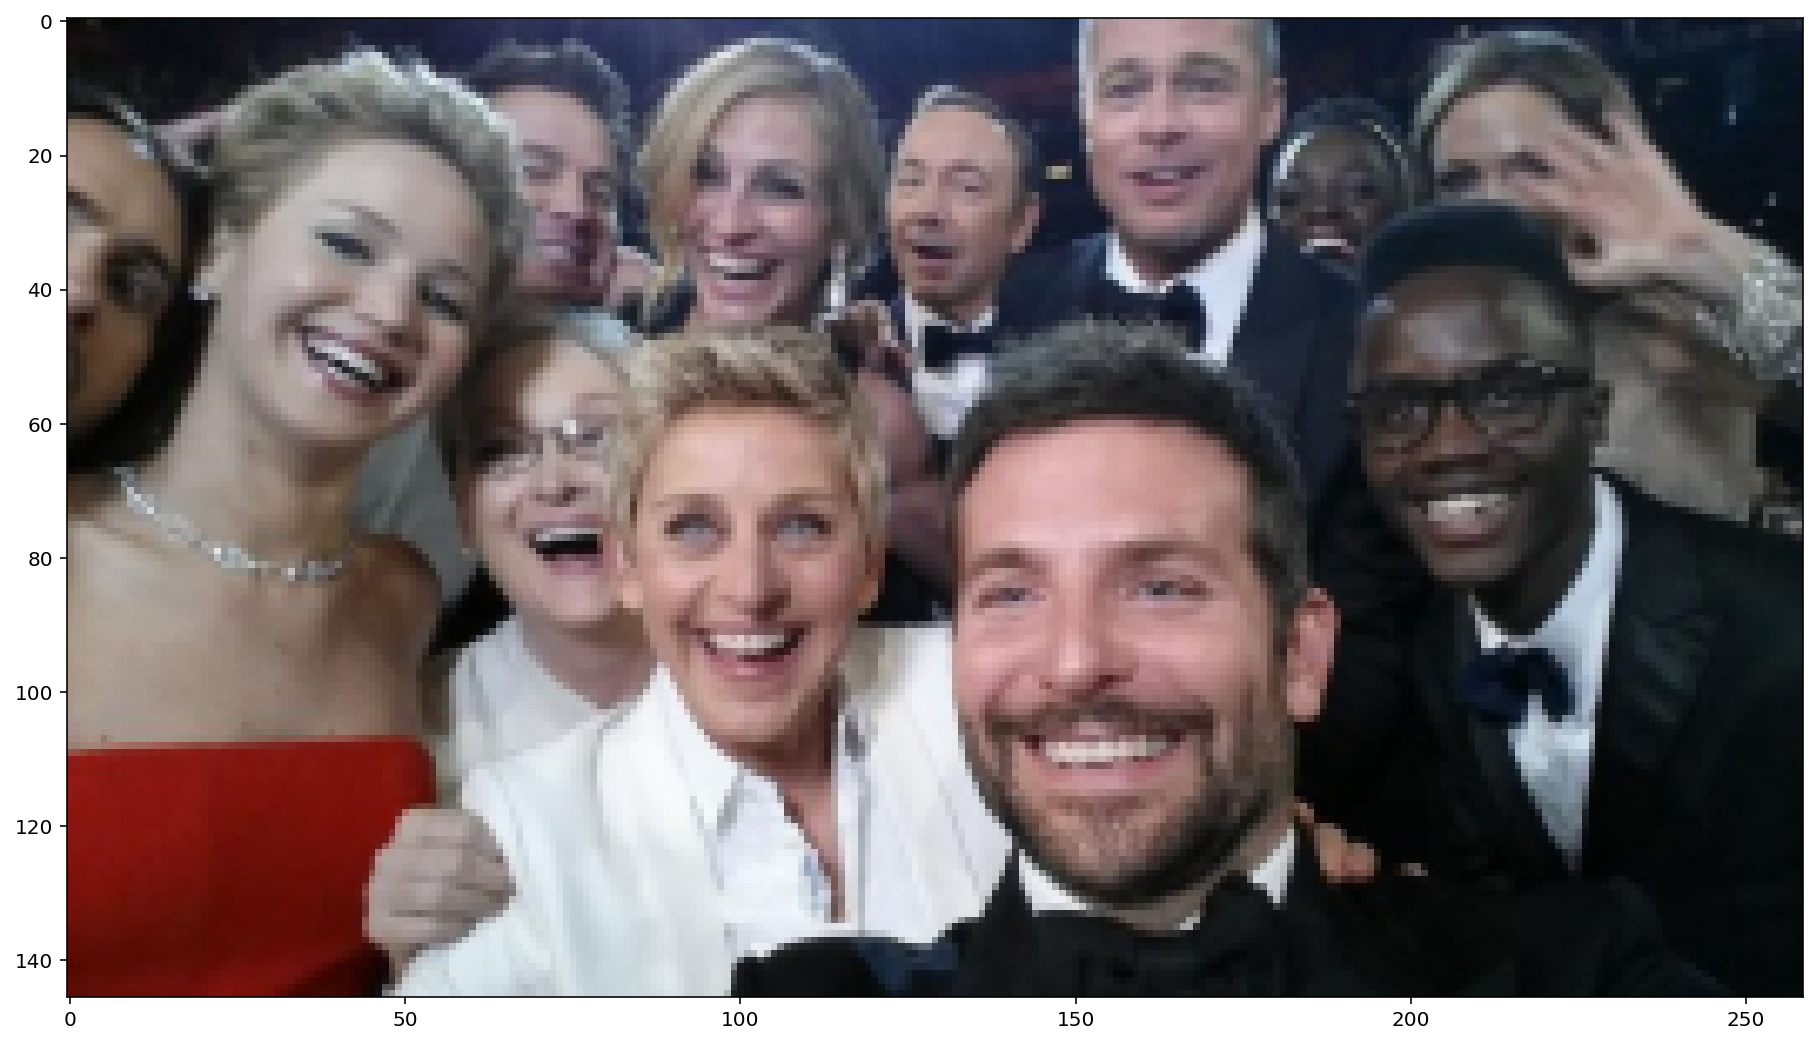

In [15]:
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.image as mpimg

img=mpimg.imread('notebooks/ellen_selfie_oscars.jpg')
down_img = rescale(img, 0.4)
fig, ax = plt.subplots(1,1, figsize=(17,9))
imgplot = ax.imshow(down_img)

In [16]:
down_img.shape

(146, 259, 3)

In [17]:
from torch.utils.data import Dataset
from torchvision import transforms

COLOUR_BLACK = torch.tensor([0.0, 0.0, 0.0])

class SingleImage(Dataset):
    def __init__(self, img, transforms_list=[transforms.ToTensor()], missing_px_color=COLOUR_BLACK):
        self.shape = down_img.shape[-1:] + down_img.shape[:-1]
        self.missing_px_color = missing_px_color
        self.img = img
        self.transforms = transforms.Compose(transforms_list)
    
    def __getitem__(self, i):
        return self.transforms(self.img).float(), 0
    
    def __len__(self):
        return 1

In [18]:
img = SingleImage(down_img[..., :3], missing_px_color=torch.tensor([0.0, 0.0, 1.0])) # remove transparency

# One Shot Inference 

In [19]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE

In [28]:
def plot_concat(nnz=.1):
    rm = RandomMasker(min_nnz=nnz, max_nnz=nnz)
    
    grid_ccp=plot_posterior_img(img, 
                         GridCntxtTrgtGetter(context_masker=rm, 
                                             target_masker=no_masker), 
                         trainers['celeba32/GridedCCP/run_0'].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=1,
                         is_uniform_grid=True,
                         is_hrztl_cat=True,
                         is_return=True)

    grid_anp=plot_posterior_img(img, 
                         GridCntxtTrgtGetter(context_masker=rm, 
                                             target_masker=no_masker), 
                         trainers['celeba32/SelfAttnCNP/run_0'].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=1,
                         is_uniform_grid=False,
                         is_hrztl_cat=True,
                         is_return=True)
    
    out=torch.cat((grid_ccp, grid_anp[:,:,264:]), dim=2)
    
    fig, ax = plt.subplots(figsize=(27,19))
    ax.imshow(out.permute(1, 2, 0).numpy())
    ax.axis("off")

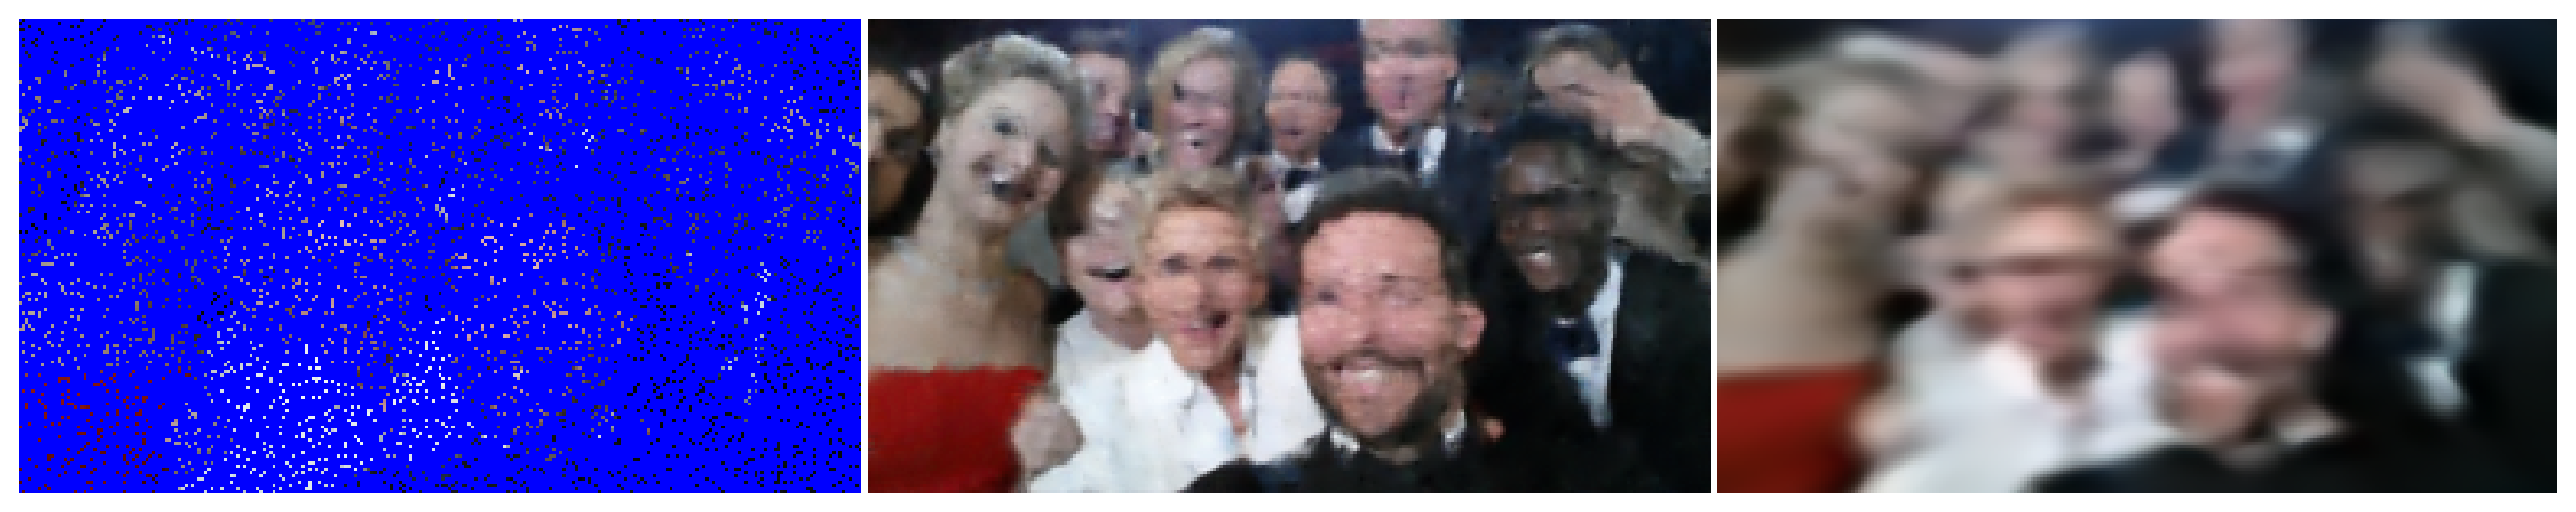

In [29]:
plot_concat(nnz=.1)

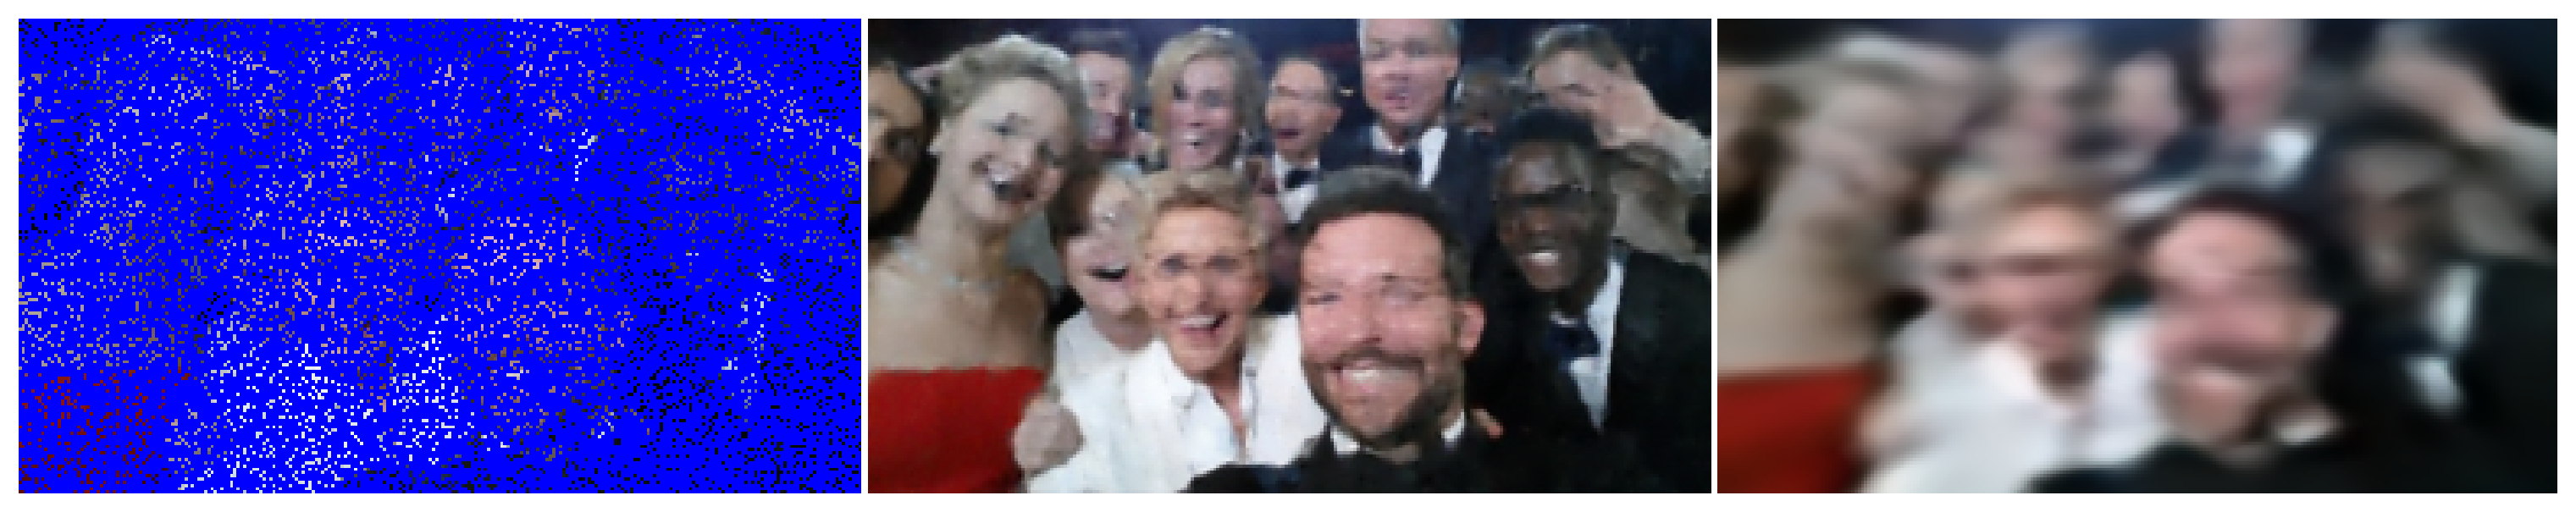

In [30]:
plot_concat(nnz=.15)

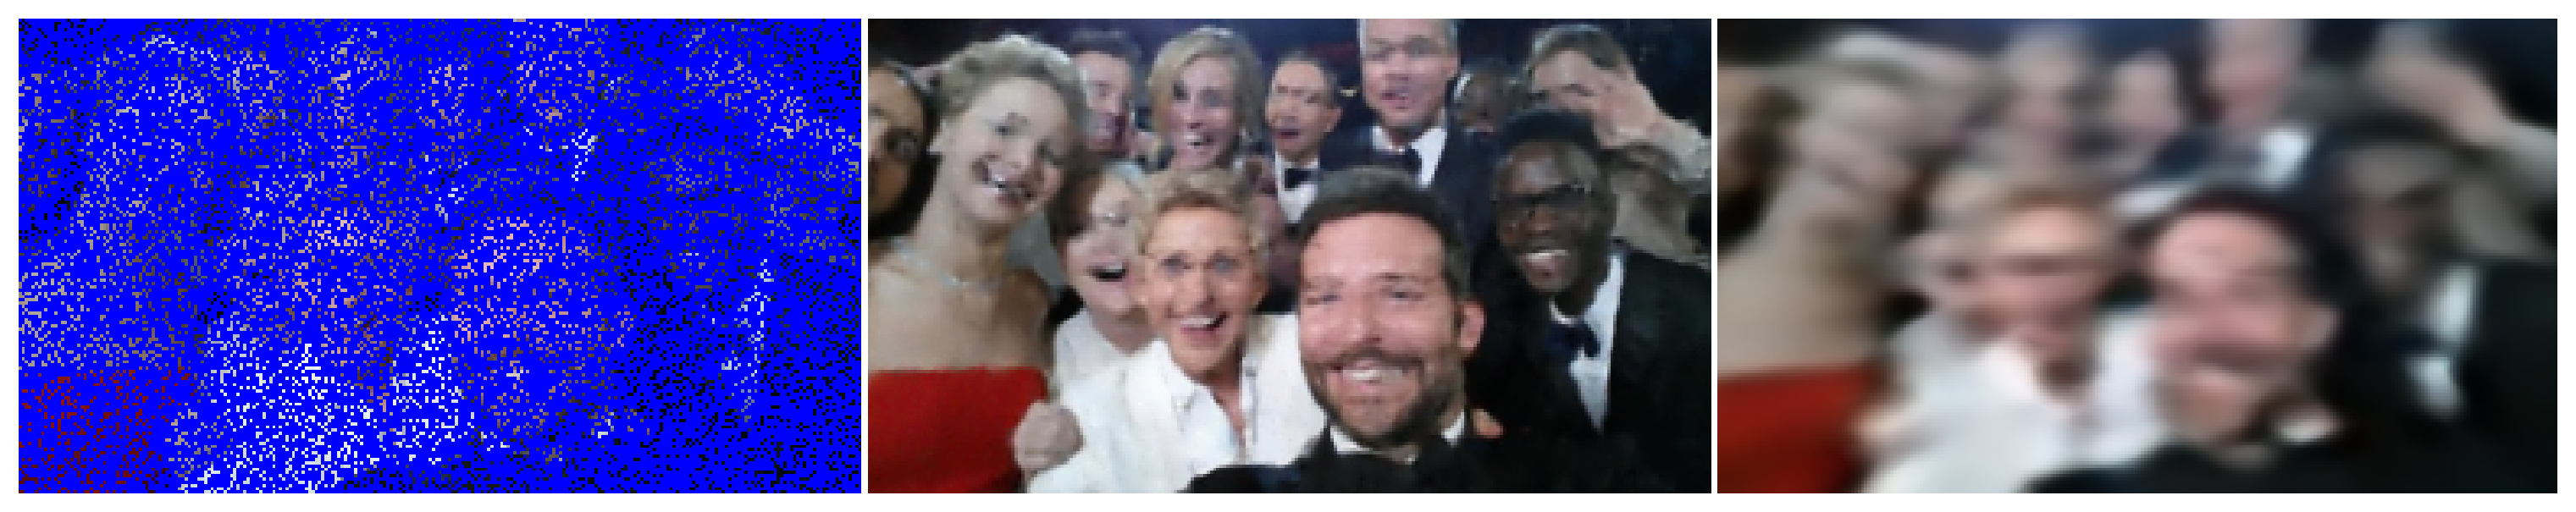

In [31]:
plot_concat(nnz=.2)

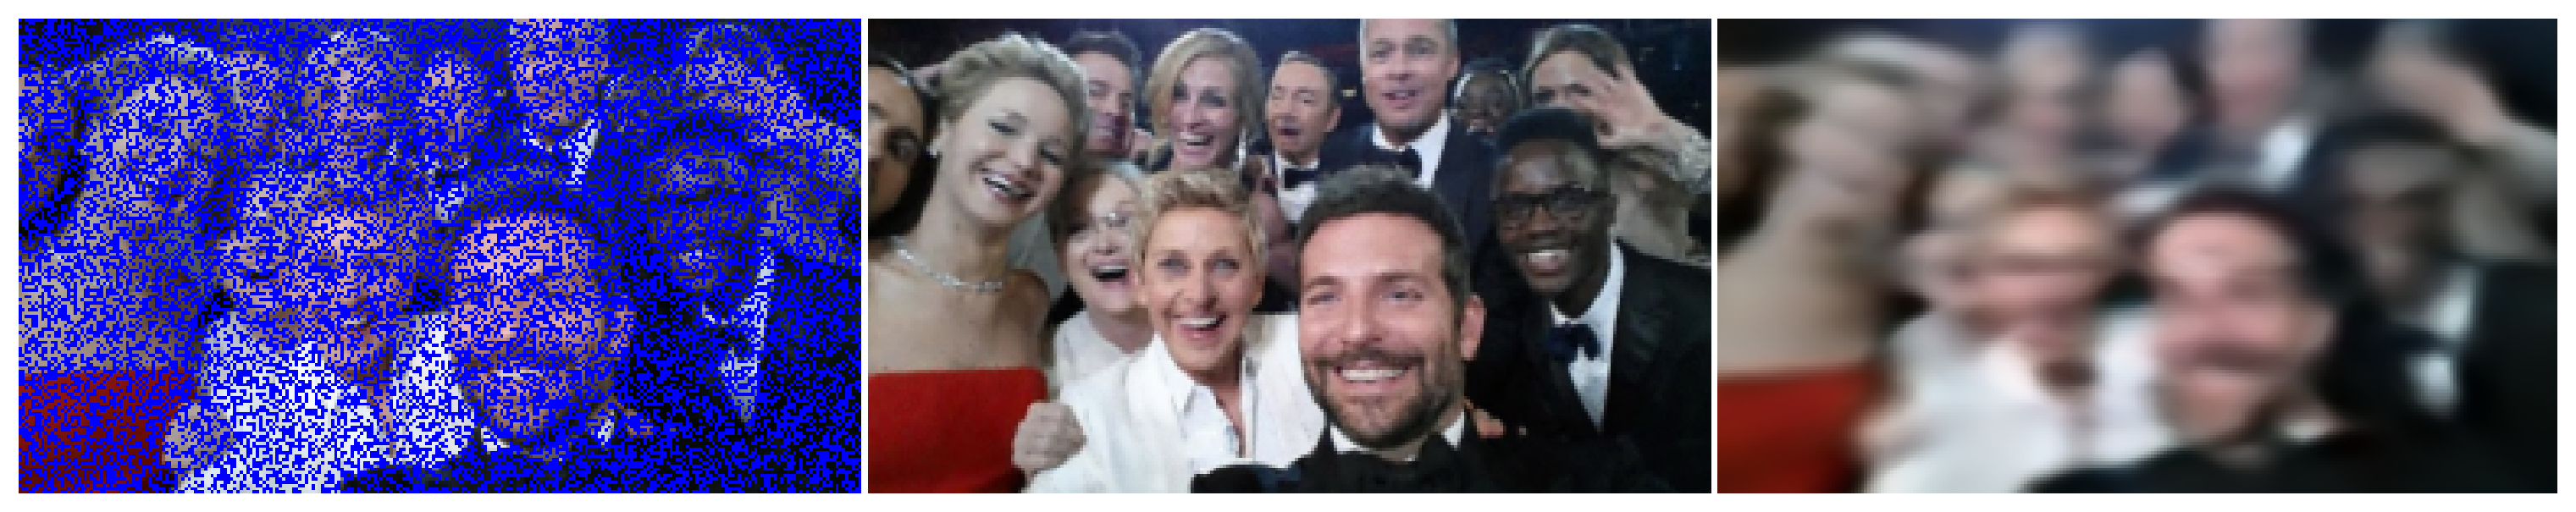

In [32]:
plot_concat(nnz=.5)

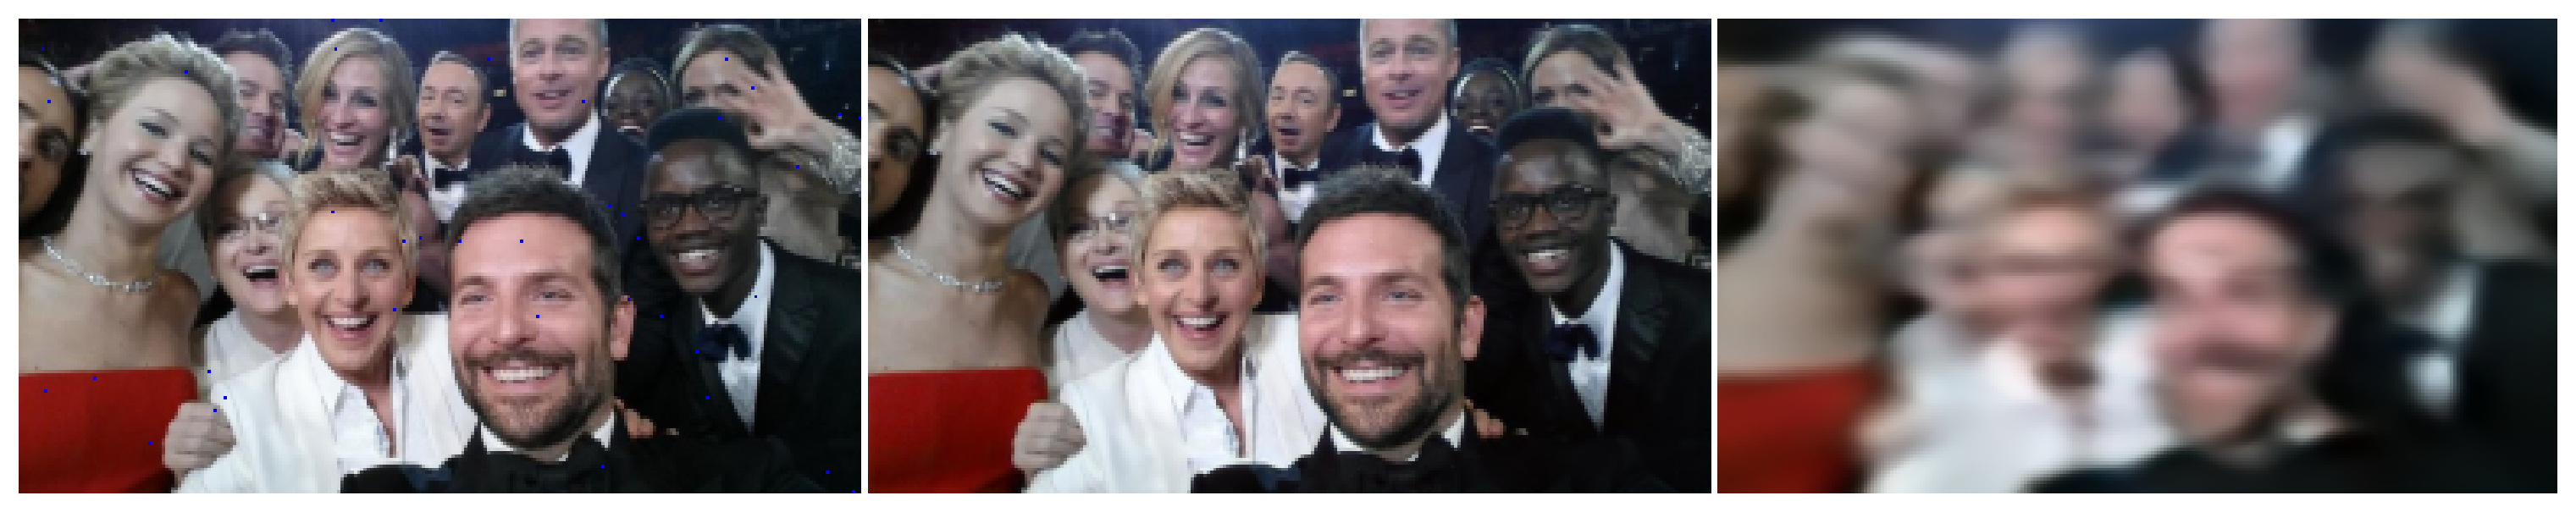

In [34]:
plot_concat(nnz=0.999)